### **Preparation**

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import math
from google.colab import files
from collections import deque
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split
import zipfile
import io
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Text Data**
- the data directory ('movie_review') consists of two sub-directories ('pos') and ('neg') for positive and negative, respectively
- each sub-directory includes a list of files for review texts
- the preprocessing given by the below codes transforms each text into the frequency information

In [2]:
uploaded = files.upload()

Saving pos.zip to pos.zip


In [3]:
pos = deque()   #positive review를 모아둔 deque, size = 1000
with zipfile.ZipFile('pos.zip') as z:
    for filename in z.namelist():
        if not os.path.isdir(filename):
            # read the file
            with z.open(filename) as f:
                for data in f:
                  lines = f.readlines()
                  pos.append(lines)
print(pos[0])

[b"for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen . \n", b'to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . \n', b'the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . \n', b"in other words , don't dismiss this film because of its source . \n", b"if you can get past the whole comic book thing , you might find another stumbling block in from hell's directors , albert and allen hughes . \n", b"getting the hughes brothers to direct this seems almost as ludicrous as casting carrot top in , well , anything , but riddle me this : who better to direct a film that's set in the ghetto and features really violent street crime than the mad geniuses behind menace ii society ? \n", b"the ghet

In [4]:
uploaded = files.upload()

Saving neg.zip to neg.zip


In [5]:
neg = deque()   #negative review를 모아둔 deque, size = 1000
with zipfile.ZipFile('neg.zip') as z:
    for filename in z.namelist():
        if not os.path.isdir(filename):
            # read the file
            with z.open(filename) as f:
                for data in f:
                  lines = f.readlines()
                  neg.append(lines)
print(neg[999])

[b'while getting themselves into trouble in nightclub after nightclub . \n', b'it\'s barely enough to sustain a three-minute _saturday_night_live_ skit , but _snl_ producer lorne michaels , _clueless_ creator amy heckerling , and paramount pictures saw something in the late night television institution\'s recurring " roxbury guys " sketch that would presumably make a good feature . \n', b'emphasis on the word " presumably . " \n', b"_a_night_at_the_roxbury_ takes an already-thin concept and tediously stretches it far beyond the breaking point--and that of viewers' patience levels . \n", b'the first five minutes or so of _roxbury_ play very much like one of the original " roxbury guys " skits . \n', b'with " what is love ? " \n', b'blaring on the soundtrack , the brotherly duo of doug and steve butabi ( chris kattan and will ferrell ) bob their heads , scope out " hotties " at clubs , and then bump a select few with violent pelvic thrusts . \n', b'there is one crucial difference , howev

### **Data Preprocessing**
- Remove unnecessary characters
- Lemmatization
- CountVectorizer  
- TFidVectorizer

In [106]:
documents = []
Y = np.empty(2000, dtype=int)
pos_documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, 1000):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(pos[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    pos_documents.append(document)
    documents.append(document)
print(len(pos_documents))
print(pos_documents[0])

neg_documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, 1000):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(neg[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    neg_documents.append(document)
    documents.append(document)
print(len(neg_documents))
print(neg_documents[999])

print("=============================================")

X_train = []
X_test = []
"""
for i in range(0, 1000):
  if i < 700:
    X_train.append(pos_documents[i])
  else:
    X_test.append(pos_documents[i])

for i in range(0, 1000):
  if i < 700:
    X_train.append(neg_documents[i])
  else:
    X_test.append(neg_documents[i])

print(len(X_train))
print(len(X_test))
"""
Y_train  = np.empty(1400, dtype=int)    # 1 - 700개, 0 - 700개 순으로 이루어진 numpy 배열
Y_test  = np.empty(600, dtype=int)      # 1 - 300개, 0 - 300개 순으로 이루어진 numpy 배열
"""
for i in range(0, 1400):
  if i < 700:
    Y_train[i] = 1
  else:
    Y_train[i] = 0

for i in range(0, 600):
  if i < 300:
    Y_test[i] = 1
  else:
    Y_test[i] = 0

print(Y_train[699], Y_train[1399])
print(Y_test[299], Y_test[599])
"""
for i in range(0, 2000):
  if i < 1000:
    Y[i] = 1
  else:
    Y[i] = 0

tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features=1500)
X = tfidf_vectorizer.fit_transform(documents).toarray()
print("vectorizer:",X[0])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1000)

"""
#vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
vectorizer = CountVectorizer(max_features=1500, min_df=0, lowercase=False)
X_train = vectorizer.fit_transform(X_train).toarray()

tfidfconverter = TfidfTransformer()
X_train = tfidfconverter.fit_transform(X_train).toarray()
X_train = X_train.T

X_test = vectorizer.fit_transform(X_test).toarray()
X_test = tfidfconverter.fit_transform(X_test).toarray()
"""
X_train = X_train.T
X_test = X_test.T

print(len(X_train))         # 1500
print(X_train[0])
print(len(X_train[0]))      # 1400
print(X_train.shape)        # size : 1500 x 1400, data 1400개이며, 각 data마다 1500개의 특징이 추출됨! 
print(X_test.shape)         # size : 1500 x 600, data 600개이며, 각 data 마다 1500개의 특징이 추출됨!

1000
for starter it wa created by alan moore and eddie campbell who brought the medium to whole new level in the mid 80 with 12 part series called the watchman b to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look little odd b the book or graphic novel if you will is over 500 page long and includes nearly 30 more that consist of nothing but footnote b in other word don dismiss this film because of it source b if you can get past the whole comic book thing you might find another stumbling block in from hell director albert and allen hughes b getting the hughes brother to direct this seems almost a ludicrous a casting carrot top in well anything but riddle me this who better to direct film that set in the ghetto and feature really violent street crime than the mad genius behind menace ii society b the ghetto in question is of course whitechapel in 1888 london east end b it a filthy sooty place where the w

### **Neural Network Architecture**
- build a classifier using neural networks for the text cateogrization with binary labels that are either positive or negative
- construct a neural network that consists of an input layer, an output layer and a sequence of hidden layers
- each hidden layer is defined by a logistic unit
- a logistic unit consists of a fully connected layer with a bias followed by the sigmoid activation function 
- the dimensions of the layers are defined by:
    - input unit : 1500 (+ a bias)
    - hidden unit : 39 (+ a bias)
    - output unit : 1

In [0]:
def forward(theta, value):
  #print(theta.shape, value.shape)
  #print("Theta", theta.shape)
  #print("value", value.shape)
  result = np.matmul(theta, value)
  return result

In [0]:
def sigmoid(value):
  """
  length = len(value)
  for i in range(0, length):
    value[i] = 1 / (1 + np.exp(-value[i]))
  """
  #value = value.astype(float)
  value = np.multiply(value,-1)
  value = np.exp(value)
  value = np.add(1,value)
  value = np.divide(1, value)
  return value

In [0]:
def addBias(value, bias):
  """
  length = len(bias)
  for i in range(0, length):
    value[i] += bias[i]
  """
  value = np.add(value, bias)
  return value

In [0]:
def neuralNet(x, u, v, bias0, bias1):    #data, theta0, theta1, theta2, bias0, bias1, bias2
  y_hat = forward(u, x)
  y_hat = addBias(y_hat, bias0)
  y = sigmoid(y_hat)
  z_hat = forward(v, y)
  z_hat = addBias(z_hat, bias1)
  z = sigmoid(z_hat)
  """
  h_hat = forward(w, z)
  h_hat = addBias(h_hat, bias2)
  h = sigmoid(h_hat)
  """
  return y, z

### **Objective Function**
- $J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=0}^{9}( - l^{(i)}_k \log( h^{(i)}_k ) - (1 - l^{(i)}_k) \log(1 - h^{(i)}_k) ) + \frac{\lambda}{2 n} \sum_{j=1}^n \theta_j^2$ 
- $\theta_j$ denotes a model parameter where $j = 1, 2, \cdots, n$
- $\lambda$ is a control parameter for the regularization based on the $L_2^2$-norm (weight decay)
- $n$ is the total number of all the model parameters over the entire neural network
- $h^{(i)}_k$ denotes the $k$-th element of the output layer for $i$-th sample data

In [0]:
def objectiveFunction(data, l, lamda, y, z, theta0, theta1, b0, b1):     #list_image[:, count], list_label -> traing과 test 구분해야겠다.!!
  length = len(data[0])                    #두는 이유는 trainig 1400, test 600개  갯수가 달라서
  #print("lshape:",l.shape,l)
  #print("zshpae",z.shape,z)
  #kk = np.multiply(l,z)
  #print("-lz",kk.shape,kk)
  cost1 = np.log(z)      # **** y size : 10x 1000 바꾸기(main, neural net)
  cost1 = np.multiply(cost1, l)
  cost1 = np.multiply(cost1, -1)
  cost2 = np.subtract(1, z)
  cost2 = np.log(cost2)
  temp = np.subtract(1, l)
  cost2 = np.multiply(cost2, temp)
  cost = np.subtract(cost1, cost2)
  cost = np.sum(cost)
  cost = np.divide(cost,length)
  cost_r1 = np.multiply(theta0, theta0)
  cost_r1 = np.sum(cost_r1)
  cost_r2 = np.multiply(theta1, theta1)
  cost_r2 = np.sum(cost_r2)
  cost_b1 = np.multiply(b0, b0)
  cost_b1 = np.sum(cost_b1)
  cost_b2 = np.multiply(b1, b1)
  cost_b2 = np.sum(cost_b2)
  cost_r = np.add(cost_r1, cost_r2)
  cost_b = np.add(cost_b1, cost_b2)
  cost_r = np.add(cost_r, cost_b)
  cost_r = cost_r * lamda / (2*15021)          #추후에 theta 추가나 값 size 변경시 이곳 변경!!!!! n = theta의 총 갯수
  cost += cost_r
  
  return cost

### **Gradient Descent (Back-propagation)**
- $\theta_{k}^{(t+1)} = \theta_{k}^{(t)} - \alpha \frac{\partial J(\theta^{(t)})}{\partial \theta_{k}}$, for all $k$
- you should choose a learning rate $\alpha$ in such a way that the convergence is achieved
- you can use random initial conditions $\theta_k^{(0)}$ for all $k$ following a normal distribution with mean 0 and stardard deviation some number

In [0]:
def gradientDescent(data, l, lamda, learning_rate, y, z, theta0, theta1, b0, b1):
  lr = learning_rate
  length = len(data[0])
  x_transpose = data.T
  y_transpose = y.T

  #######theta1
  partial_1 = np.subtract(z, l)
  partial_theta1 = np.matmul(partial_1, y_transpose)
  regular_theta1 = np.sum(theta1)
  regular_theta1 = np.multiply(regular_theta1, lamda)
  regular_theta1 = np.divide(regular_theta1, 10) 
  partial_theta1 = np.add(partial_theta1, regular_theta1)
  partial_theta1 = np.multiply(partial_theta1, lr)
  theta1 = np.subtract(theta1, partial_theta1)
  

  #######bias1
  partial_bias1 = np.ones((1400,1), dtype=float)
  partial_bias1 = np.matmul(partial_1, partial_bias1)
  partial_bias1 = np.divide(partial_bias1, 1400)      ## 확실치 않음 없애야할수도 있다!
  partial_bias1 = np.multiply(partial_bias1, lr)
  b1 = np.subtract(b1, partial_bias1)

  #######theta0
  theta1_transpose = theta1.T
  partial_0 = np.matmul(theta1_transpose, partial_1)      #어쩌면 theta1 transose 한 것을 ㄴ허어야할수 있다.
  partial_theta0 = np.matmul(partial_0, x_transpose)
  regular_theta0 = np.sum(theta0)
  regular_theta0 = np.multiply(regular_theta0, lamda)
  regular_theta0 = np.divide(regular_theta0, 15000) 
  partial_theta0 = np.add(partial_theta0, regular_theta0)
  partial_theta0 = np.multiply(partial_theta0, lr)
  theta0 = np.subtract(theta0, partial_theta0)

  #######bias0
  partial_bias0 = np.ones((1400,1), dtype=float)
  partial_bias0 = np.matmul(partial_0, partial_bias0)
  partial_bias0 = np.divide(partial_bias0, 1400)      ## 확실치 않음 없애야할수도 있다!
  partial_bias0 = np.multiply(partial_bias0, lr)
  b0 = np.subtract(b0, partial_bias0)

  return theta0, b0, theta1, b1

In [0]:
def checkAccuracy(data, label, z, theta0, b0):
  length = len(label)
  count = 0
  z = z.T
  
  for i in range(0, length):
    if z[i] >= 0.5:
      result = 1
    if z[i] < 0.5:
      result = 0
    if label[i] == result:
      count += 1
  accuracy = count / length * 100
  
  return accuracy

In [0]:
def predClassifier(z):
  z = z.T
  length = len(z)
  result  = np.empty(length, dtype=int)

  for i in range(0, length):
    if z[i] >= 0.5:
      result[i] = 1
    else:
      result[i] = 0

  return result

In [0]:
train_costs = deque()
test_costs = deque()
theta_0s = deque()
theta_1s = deque()
theta_2s = deque()
bias_0s = deque()
bias_1s = deque()
bias_2s = deque()
iters = deque()
train_accuracys = deque()
test_accuracys = deque()
predict_train = deque()
predict_test = deque()

In [108]:
def main():
  mu = 0
  sigma = 0.1
  lamda = 0.1

  theta_0 = np.random.normal(mu, sigma, size=(10,1500))   #size = 196x784
  theta_1 = np.random.normal(mu, sigma, size=(1,10))    #size = 49x196
  #theta_2 = np.random.normal(mu, sigma, size=(10,49))     #size = 10x49
  
  b_0 = np.random.normal(mu, sigma, size=(10,1))  
  b_1 = np.random.normal(mu, sigma, size=(1,1))                  
  #b_2 = np.random.normal(mu, sigma, 10)                   #size = 10x1

  lr = 0.00005                                                #learning rate

  #training step
  for iter in range(0, 10000):
    iters.append(iter)
    y, z = neuralNet(X_train, theta_0, theta_1, b_0, b_1)
    #print("y",y)
    train_cost = objectiveFunction(X_train, Y_train, lamda, y, z, theta_0, theta_1, b_0, b_1)  #print(cost)
    print("traincost",train_cost)
    print("##########################################111111111111111111111111111111",iter)
    train_costs.append(train_cost)
    theta_0, b_0, theta_1, b_1 = gradientDescent(X_train, Y_train, lamda, lr, y, z, theta_0, theta_1, b_0, b_1)
    #print("b0", b_0)
    #############train accuracy 하자!############
    train_accuracy = checkAccuracy(X_train, Y_train, z, theta_0, b_0)
    print("TRAIN_ACC :",train_accuracy)
    train_accuracys.append(train_accuracy)
    #print("##########################################12222222222")

    #########test
    y, z = neuralNet(X_test, theta_0, theta_1, b_0, b_1)
    test_cost = objectiveFunction(X_test, Y_test, lamda, y, z, theta_0, theta_1, b_0, b_1)
    #print("##########################################33333333333")
    test_costs.append(test_cost)
    print("testcost",test_cost)
    #############test accuracy
    test_accuracy = checkAccuracy(X_test, Y_test, z, theta_0, b_0)
    print("TEST_ACC :",test_accuracy)
    test_accuracys.append(test_accuracy)
    #train_y, train_z, train_h = neuralNet(train_image, theta_0, theta_1, theta_2, b_0, b_1, b_2) #image 문제
    #print("##########################################4444444444444444444")
    #theta_0s.append(theta_0)
    #bias_0s.append(b_0)
    theta_0s.append(theta_0)
    theta_1s.append(theta_1)
    bias_0s.append(b_0)
    bias_1s.append(b_1)
  
  y, z = neuralNet(X_train, theta_0, theta_1, b_0, b_1)
  train_z = predClassifier(z)
  predict_train.append(train_z)
  y, z = neuralNet(X_test, theta_0, theta_1, b_0, b_1)
  test_z = predClassifier(z)
  predict_test.append(test_z)


if __name__ == "__main__":
  main()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
##########################################111111111111111111111111111111 9000
TRAIN_ACC : 96.64285714285714
testcost 0.36860273902993346
TEST_ACC : 85.0
traincost 0.17457192249006476
##########################################111111111111111111111111111111 9001
TRAIN_ACC : 96.64285714285714
testcost 0.36859762659304146
TEST_ACC : 85.0
traincost 0.1745371977718489
##########################################111111111111111111111111111111 9002
TRAIN_ACC : 96.64285714285714
testcost 0.3685925221469244
TEST_ACC : 85.0
traincost 0.17450248308016483
##########################################111111111111111111111111111111 9003
TRAIN_ACC : 96.64285714285714
testcost 0.36858742568772773
TEST_ACC : 85.0
traincost 0.17446777841114844
##########################################111111111111111111111111111111 9004
TRAIN_ACC : 96.64285714285714
testcost 0.3685823372115986
TEST_ACC : 85.0
traincost 0.17443308376093758
##########################################1111111111

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

                 
                   

### **1. Plot the loss curve**

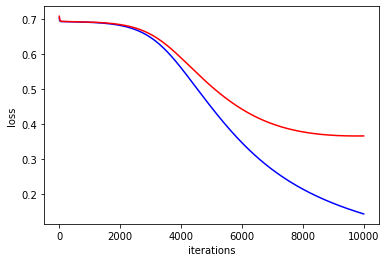

In [109]:
fig = plt.figure()
#print(train_costs)
graph1 = plt.plot(iters, train_costs, 'b')
graph2 = plt.plot(iters, test_costs, 'r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

### **2. Plot the accuracy curve**

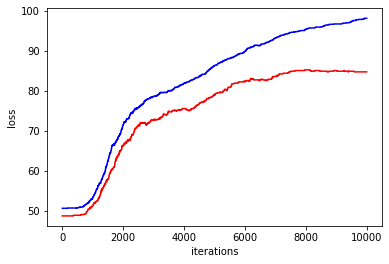

In [110]:
fig = plt.figure()
graph3 = plt.plot(iters, train_accuracys, 'b')
graph4 = plt.plot(iters, test_accuracys, 'r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

### **3. Plot the accuracy value**

In [111]:
final_train_accuracy = train_accuracys[-1]
final_test_accuracy = test_accuracys[-1]
print("final_train_accuracys :", final_train_accuracy,"%")
print("final_test_accuracys :", final_test_accuracy,"%")

final_train_accuracys : 98.07142857142857 %
final_test_accuracys : 84.66666666666667 %


### **4. Plot the classification example**

In [112]:
print("Training results")
print(confusion_matrix(Y_train, predict_train[0]))
print(classification_report(Y_train, predict_train[0]))
print(accuracy_score(Y_train, predict_train[0]))

print("Testing results")
print(confusion_matrix(Y_test, predict_test[0]))
print(classification_report(Y_test, predict_test[0]))
print(accuracy_score(Y_test, predict_test[0]))

Training results
[[672  20]
 [  7 701]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       692
           1       0.97      0.99      0.98       708

    accuracy                           0.98      1400
   macro avg       0.98      0.98      0.98      1400
weighted avg       0.98      0.98      0.98      1400

0.9807142857142858
Testing results
[[251  57]
 [ 35 257]]
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       308
           1       0.82      0.88      0.85       292

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600

0.8466666666666667
